In [ ]:
!pip install pytorch-tabnet
!pip install itertools

In [3]:
# Import necessary libraries

# Overall
import pandas as pd
import numpy as np

# For data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.combine import SMOTETomek
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier

# For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For XGBoost
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# For TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
import itertools

# For evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.utils.class_weight import compute_class_weight

# For hyperparameter tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Section 1: Data Loading and Inspection

In [ ]:
# First manually upload the csv to the files and load the data
data = pd.read_csv('application_data.csv')

In [ ]:
# Inspect the data
print("The information of the data is: ", end = '\n\n')
print(data.info(), end = '\n\n')
print("The dimensions of the data is:", data.shape)

The information of the data is: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

The dimensions of the data is: (307511, 122)


# Section 2: Data Preprocessing


Step 2.1: Handle Variables with High Missing Percentage


In [ ]:
# Count missing values for each column and get the percentage of missing values
missing_percentage = data.isna().mean() * 100
print("The missing percentages are: \n" + str(missing_percentage.sort_values(ascending = True)))

The missing percentages are: 
SK_ID_CURR                      0.000000
HOUR_APPR_PROCESS_START         0.000000
REG_REGION_NOT_WORK_REGION      0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
                                 ...    
NONLIVINGAPARTMENTS_MEDI       69.432963
NONLIVINGAPARTMENTS_MODE       69.432963
COMMONAREA_MODE                69.872297
COMMONAREA_AVG                 69.872297
COMMONAREA_MEDI                69.872297
Length: 122, dtype: float64


In [ ]:
# Bin the missing percentages into 7 equal intervals since we have about 0% to 70%
bin_counts = pd.cut(missing_percentage, bins = 7, right = False).value_counts().sort_index()

# Display the result
print("The distribution of the missing percentages are: \n" + str(bin_counts))

The distribution of the missing percentages are: 
[0.0, 9.982)        65
[9.982, 19.964)      7
[19.964, 29.945)     0
[29.945, 39.927)     1
[39.927, 49.909)     8
[49.909, 59.891)    24
[59.891, 69.942)    17
Name: count, dtype: int64


In [ ]:
# Keep the columns with missing percentage less than 20% as seen from the distribution
data_1 = data.loc[:, missing_percentage <= 20]

# Since there must still be some of the entries missing, those entry will be discarded
data_2 = data_1.dropna()

# Remove the variables with the same data (which are FLAG_DOCUMENT_2 and FLAG_MOBIL after inspection)
data_3 = data_2.loc[:, data_2.nunique() > 1]

# Check the information of the data
print("The information of the cleaned data is: \n")
print(data_3.info())

The information of the cleaned data is: 

<class 'pandas.core.frame.DataFrame'>
Index: 244280 entries, 0 to 307510
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   244280 non-null  int64  
 1   TARGET                       244280 non-null  int64  
 2   NAME_CONTRACT_TYPE           244280 non-null  object 
 3   CODE_GENDER                  244280 non-null  object 
 4   FLAG_OWN_CAR                 244280 non-null  object 
 5   FLAG_OWN_REALTY              244280 non-null  object 
 6   CNT_CHILDREN                 244280 non-null  int64  
 7   AMT_INCOME_TOTAL             244280 non-null  float64
 8   AMT_CREDIT                   244280 non-null  float64
 9   AMT_ANNUITY                  244280 non-null  float64
 10  AMT_GOODS_PRICE              244280 non-null  float64
 11  NAME_TYPE_SUITE              244280 non-null  object 
 12  NAME_INCOME_TYPE     

Section 2.2: Handle Imbalanced Response Variable 

In [ ]:
print("Note that the distribution for TARGET is: \n")
print(data_3['TARGET'].value_counts(), end = '\n\n')
print("The percentage of 1s is only", round(data_3['TARGET'].value_counts()[1]/data_3['TARGET'].count() * 100, 3), "%, indicating it is highly imbalanced.")

Note that the distribution for TARGET is: 

TARGET
0    225248
1     19032
Name: count, dtype: int64

The percentage of 1s is only 7.791 %, indicating it is highly imbalanced.


In [ ]:
# Set seed to ensure reproducibility
np.random.seed(4510)

In [ ]:
### This part is to one-hot encode the dataset, separate the training and test sets and standardize the data ###

# Perform one-hot encoding on categorical variables
data_4 = pd.get_dummies(data_3)

# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(data_4.drop('TARGET', axis = 1),
                                                    data_4['TARGET'], test_size = 0.2, random_state = 17)

# Standardise the data (not applicable to response variable for classification problem)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

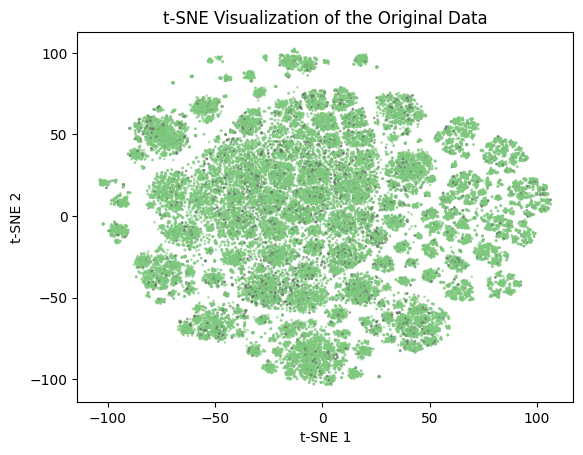

In [ ]:
### This part is to visualize (a small portion of) the original data using t-SNE after applying PCA ###

# Apply PCA on the original data to reduce dimensions
pca = PCA(n_components = 50, random_state = 17)
x_train_orig_scaled_pca = pca.fit_transform(x_train_scaled)

# Perform stratified sampling to preserve class distribution and only use 25% of the whole dataset as it is too large
x_train_orig_scaled_subsampled, _, y_train_subsampled, _ = train_test_split(
    x_train_orig_scaled_pca, y_train,
    test_size = 0.75, random_state = 17, stratify = y_train
)

# Perform t-SNE on the subset of the original data
tsne = TSNE(n_components = 2, random_state = 17)
x_train_tsne = tsne.fit_transform(x_train_orig_scaled_subsampled)

# Plot the t-SNE
plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c = y_train_subsampled, cmap = 'Accent', alpha = 0.5, s = 1)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of the Original Data')
plt.show()

# This takes around 18 minutes

In [ ]:
### This part is to perform SMOTETomek on the standardized data ###

# Show distribution before SMOTE
counter = Counter(y_train)
print("before SMOTETomek", counter)

# Perform SMOTE (Synthetic Minority Over-sampling Technique) + Tomek on the standardized data
# Oversample the "1" class such that it is a quarter the size of the "0" class
smotetomek = SMOTETomek(sampling_strategy = 0.25, random_state = 17)
x_train_scaled_smotetomek, y_train_smotetomek = smotetomek.fit_resample(x_train_scaled, y_train)

# Show distribution after SMOTE
counter = Counter(y_train_smotetomek)
print("after SMOTETomek", counter)

# This takes around 15 minutes

before SMOTETomek Counter({0: 180200, 1: 15224})
after SMOTETomek Counter({0: 179760, 1: 44610})


before SMOTETomek Counter({0: 180200, 1: 15224})
after SMOTETomek Counter({0: 179760, 1: 44610})


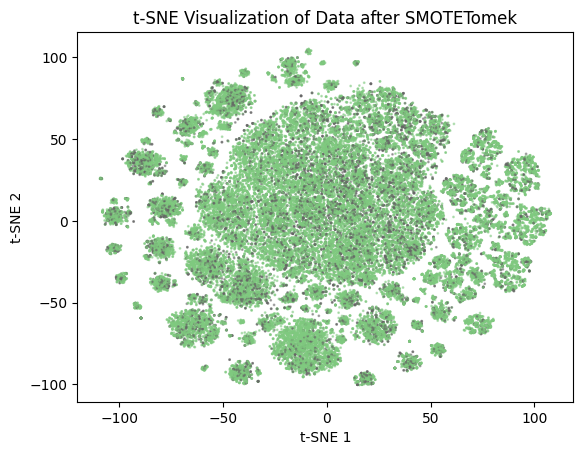

In [ ]:
### This part is to visualize (a small portion of) the data that applied SMOTETomek and PCA using t-SNE ###

# Apply PCA on the data after SMOTETomek to reduce dimensions
pca = PCA(n_components = 50, random_state = 17)
x_train_scaled_pca = pca.fit_transform(x_train_scaled_smotetomek)

# Perform t-SNE on a smaller subset rather on the whole training set
# Perform stratified sampling to preserve class distribution
x_train_pca_subsampled, _, y_train_smotetomek_subsampled, _ = train_test_split(
    x_train_scaled_pca, y_train_smotetomek,
    test_size=0.75, random_state=17, stratify=y_train_smotetomek
)

# Now perform t-SNE on this subset
tsne = TSNE(n_components = 2, random_state = 17)
x_train_tsne1 = tsne.fit_transform(x_train_pca_subsampled)

# Plot the t-SNE
plt.scatter(x_train_tsne1[:, 0], x_train_tsne1[:, 1], c = y_train_smotetomek_subsampled, cmap = 'Accent', alpha = 0.5, s = 1)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Data after SMOTETomek')
plt.show()

# This takes around 33 minutes

Section 2.3: Perform Feature Selection

In [ ]:
# Separates the numerical and categorical variables by identifying the numerical variables
num_vars = data_3.select_dtypes(include = ['float64', 'int64']).columns.tolist()

# As some of the binary variables with 0s and 1s will be included, we want to exclude them
bin_vars = [col for col in num_vars if data_3[col].nunique() == 2]

# Get the numerical variables
num_vars = [col for col in num_vars if col not in bin_vars]

# Separate the numerical and categorical data
train_data = pd.DataFrame(x_train_scaled_smotetomek, columns = x_train.columns)
num_data = train_data[num_vars]
cat_data = train_data.drop(columns = num_vars)

# Check the numerical and categorical data (Optional)
# print(num_data.head())
# print(cat_data.head())

In [ ]:
# For categorical variables, we will use chi-square test against the target (response variable)
select = []

for col in cat_data.columns:
    cross_tab = pd.crosstab(cat_data[col], y_train_smotetomek)
    chi2, p, dof, ex = chi2_contingency(cross_tab)

    if (p > 0) & (p <= 0.05):
        select.append(col)

print("The number of remaining categorical variables left are", len(select))

The number of remaining categorical variables left are 76


In [ ]:
# Utilize random forest to perform feature selection
before_rf = train_data[num_vars + select]

# Fit the Random Forest classifier to the training set
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(before_rf, y_train_smotetomek)

# Get feature importances from the Random Forest model
importances = rf.feature_importances_

# Get the indices of the most important features
indices = importances.argsort()[::-1]

# Print the feature importances
for i in range(before_rf.shape[1]):
    print(f"{i + 1}. Feature {indices[i]} (Importance: {importances[indices[i]]})")

# Select top 30 features
top_features = indices[:30]

# Get the selected features
x_train_selected = before_rf.iloc[:, top_features]

# This takes around 2 minutes

1. Feature 16 (Importance: 0.07459458297488145)
2. Feature 27 (Importance: 0.0680985979301489)
3. Feature 15 (Importance: 0.06221005900911741)
4. Feature 19 (Importance: 0.05161132522195988)
5. Feature 17 (Importance: 0.04966103912858756)
6. Feature 1 (Importance: 0.042227364060736024)
7. Feature 7 (Importance: 0.038989773862232874)
8. Feature 6 (Importance: 0.03885089639388192)
9. Feature 21 (Importance: 0.03708775177925079)
10. Feature 10 (Importance: 0.036954189002538634)
11. Feature 5 (Importance: 0.036223523063700684)
12. Feature 11 (Importance: 0.03581227617952129)
13. Feature 3 (Importance: 0.0356673260673403)
14. Feature 9 (Importance: 0.03408339362696705)
15. Feature 4 (Importance: 0.033729719739180195)
16. Feature 14 (Importance: 0.033727871470720136)
17. Feature 0 (Importance: 0.033434127036515354)
18. Feature 2 (Importance: 0.03126135706668015)
19. Feature 8 (Importance: 0.030871487633786724)
20. Feature 25 (Importance: 0.03021000977453893)
21. Feature 12 (Importance: 0.026

In [ ]:
# Final inspection on the selected training set
print("These are the variables before manual selection: \n")
print(x_train_selected.columns)

These are the variables before manual selection: 

Index(['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_2',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN',
       'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'AMT_CREDIT',
       'DAYS_REGISTRATION', 'AMT_ANNUITY', 'HOUR_APPR_PROCESS_START',
       'SK_ID_CURR', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED',
       'AMT_REQ_CREDIT_BUREAU_MON', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'NAME_HOUSING_TYPE_With parents', 'ORGANIZATION_TYPE_Other',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'NAME_HOUSING_TYPE_Municipal apartment',
       'ORGANIZATION_TYPE_Business Entity Type 2'],
      dtype='object')


In [ ]:
# We will manually exclude some of the seemingly unimportant variables
final_x_train = x_train_selected.drop(['SK_ID_CURR', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'], axis=1)

# We will do the same thing on the test set
test_data = pd.DataFrame(x_test_scaled, columns = x_test.columns)
final_x_test = test_data[final_x_train.columns]

print("These are the variables after manual selection: \n")
print(final_x_train.columns)

These are the variables after manual selection: 

Index(['AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'CNT_CHILDREN', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE',
       'CNT_FAM_MEMBERS', 'AMT_CREDIT', 'DAYS_REGISTRATION', 'AMT_ANNUITY',
       'HOUR_APPR_PROCESS_START', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED',
       'AMT_REQ_CREDIT_BUREAU_MON', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_HOUSING_TYPE_With parents',
       'ORGANIZATION_TYPE_Other', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'ORGANIZATION_TYPE_Business Entity Type 2'],
      dtype='object')


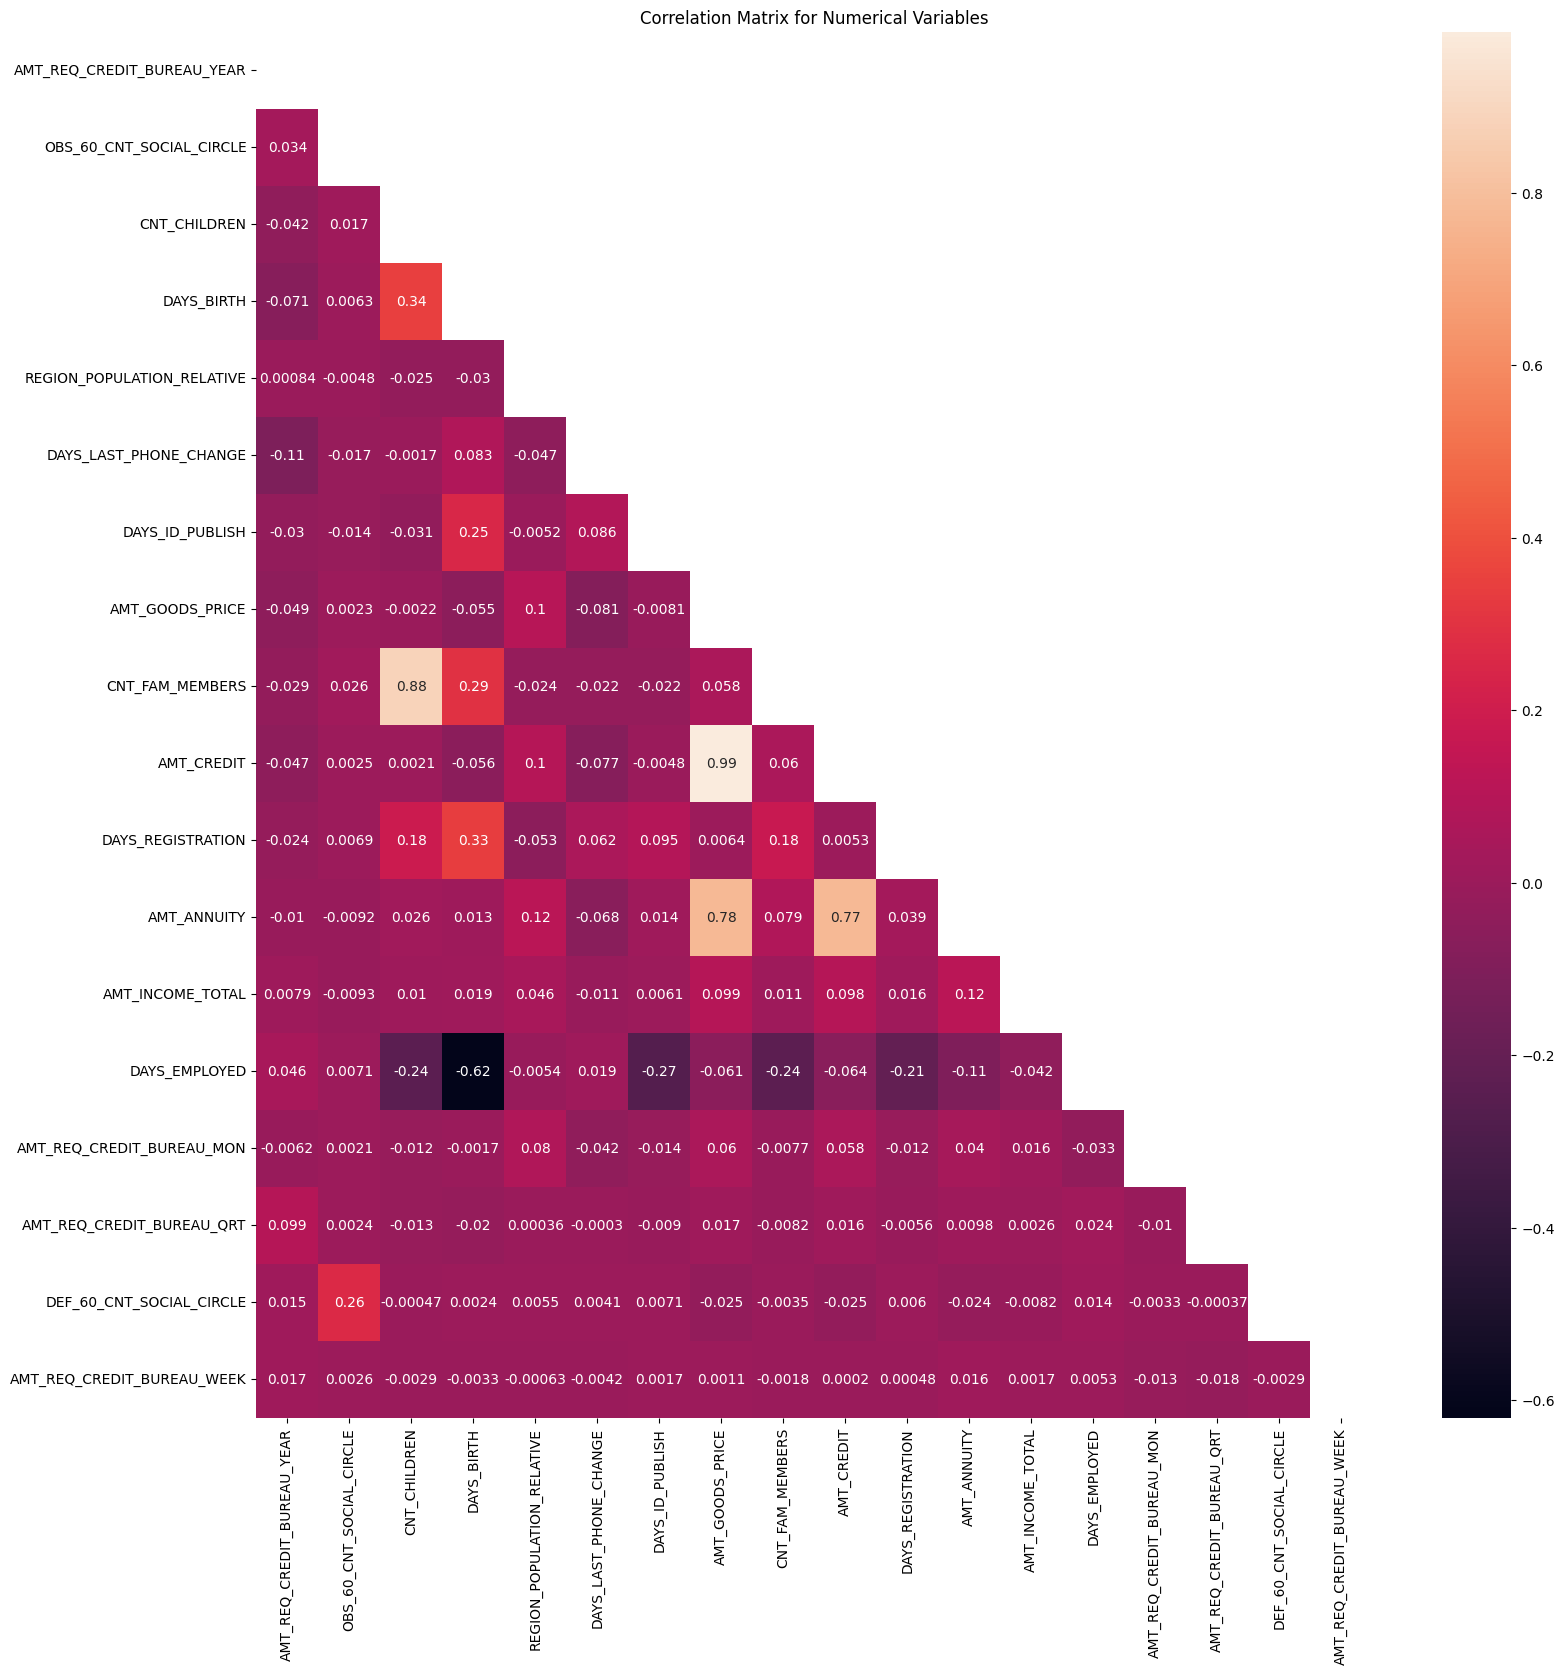

In [ ]:
# Exclude binary categorical variables (those with only 2 unique values)
final_num_vars = final_x_train.drop(['HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'NAME_HOUSING_TYPE_With parents',
                                     'ORGANIZATION_TYPE_Other', 'NAME_HOUSING_TYPE_Municipal apartment','ORGANIZATION_TYPE_Business Entity Type 2'], axis =1)
corr_matrix = final_num_vars.corr()
# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Apply the mask to the correlation matrix
masked_corr_matrix = corr_matrix.mask(mask)
plt.figure(figsize=(18, 18))
sns.heatmap(masked_corr_matrix, annot = True)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()


In [ ]:
final_x_train.describe()

,AMT_REQ_CREDIT_BUREAU_YEAR,OBS_60_CNT_SOCIAL_CIRCLE,CNT_CHILDREN,DAYS_BIRTH,REGION_POPULATION_RELATIVE,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,AMT_CREDIT,...,AMT_REQ_CREDIT_BUREAU_MON,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_60_CNT_SOCIAL_CIRCLE,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Other,AMT_REQ_CREDIT_BUREAU_WEEK,NAME_HOUSING_TYPE_Municipal apartment,ORGANIZATION_TYPE_Business Entity Type 2
count,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,...,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000,224370.000000
mean,0.004170,-0.004106,0.005369,0.035008,-0.017804,0.027891,0.021569,-0.020645,0.005847,-0.016146,...,-0.009167,0.022416,0.023913,-0.009019,0.005060,0.007882,-0.003740,-0.005974,-0.000520,0.002226
std,0.981290,0.976122,0.988088,0.987991,0.966901,0.974611,0.985532,0.968186,0.990155,0.969352,...,0.962231,0.979962,0.979951,0.977507,0.998594,1.011620,0.989709,0.976408,0.994365,1.003205
min,-1.022479,-0.585599,-0.583069,-2.111209,-1.497671,-3.810363,-2.783648,-1.363060,-1.280149,-1.392566,...,-0.293511,-2.101808,-2.084863,-0.434108,-0.274786,-0.219144,-0.239709,-0.167654,-0.193443,-0.193571
25%,-0.855371,-0.585599,-0.583069,-0.779636,-0.785210,-0.686155,-0.827265,-0.805929,-0.183159,-0.801180,...,-0.293511,-0.108506,-0.069877,-0.434108,-0.274786,-0.219144,-0.239709,-0.167654,-0.193443,-0.193571
50%,-0.211046,-0.585599,-0.583069,0.124580,-0.140324,0.251860,-0.140449,-0.260910,-0.183159,-0.216019,...,-0.293511,-0.108506,-0.069877,-0.434108,-0.274786,-0.219144,-0.239709,-0.167654,-0.193443,-0.193571
75%,0.588792,0.238363,0.791874,0.845180,0.411244,0.838755,0.837071,0.356778,0.913831,0.493867,...,-0.293511,-0.108506,-0.069877,-0.434108,-0.274786,-0.219144,-0.239709,-0.167654,-0.193443,-0.193571
max,10.793510,141.135956,25.540859,1.966448,3.783842,1.196288,2.048230,9.428314,19.562653,8.500925,...,28.460614,1.884795,1.945110,12.682530,65.749431,4.563211,4.171719,38.761264,5.169492,5.166072


# Section 3: XGBoost

In [ ]:
# XGBoost only takes numerical inputs for the response variable
# Encode y to numeric (label encorder more suitable for binary response variable)
# Fit the LabelEncoder on the training data
encoder = LabelEncoder()
encoder.fit(y_train_smotetomek)

# Transform the training and test data
y_train_encoded = encoder.transform(y_train_smotetomek)
y_test_encoded = encoder.transform(y_test)

# Extract categorical features and convert to pd.categorical
cat_cols = final_x_train.select_dtypes(include=['object']).columns
final_x_train[cat_cols] = final_x_train[cat_cols].astype('category')

# Split the data
x_train_xgb, x_val_xgb, y_train_xgb, y_val_xgb = train_test_split(final_x_train, y_train_encoded, test_size = 0.2,
                                                                  random_state = 17)

# First define the custom loss function to be used in tuning
def expected_loss(y_true, y_pred_proba, C_a, Amt_i):
    # Compute the loss for each instance
    loss = np.sum(
        y_true * (y_pred_proba * C_a + (1 - y_pred_proba) * Amt_i) +
        (1 - y_true) * (y_pred_proba * C_a)
    )
    return loss / len(y_true)  # Normalize by the number of instances

# Create classification matrices
# enable_categorical = True specify the presence of categorical variables
# for XGBoost to handle it directly without the need for one-hot encoding
dtrain_clf = xgb.DMatrix(x_train_xgb, y_train_xgb, enable_categorical = True)
dval_clf = xgb.DMatrix(x_val_xgb, y_val_xgb, enable_categorical = True)

# Train the model
params = { "objective": "binary:logistic",
          "eval_metric": "logloss",
          "subsample": 0.8, # fraction of data to use for each tree
          "colsample_bytree": 0.8, # fraction of features to use for each tree
          "gamma": 0.1, # pruning
          "lambda": 0,
          "alpha": 1, # lasso regularisation
          "scale_pos_weight": 1  # for imbalanced data
}

num_boost_round = 100
xgb_model = xgb.train(params, dtrain_clf, num_boost_round)

# Make predictions
y_pred_xgb_proba = xgb_model.predict(dval_clf)

# Convert predicted probabilities to class labels
y_pred_xgb_label = (y_pred_xgb_proba > 0.5).astype(int)

# Calculate the expected misclassification loss
C_a = 100   # Custom value
Amt_i = x_val_xgb["AMT_CREDIT"].values
loss = expected_loss(y_val_xgb, y_pred_xgb_proba, C_a, Amt_i)

# Evaluate the model using various metrics
accuracy = accuracy_score(y_val_xgb, y_pred_xgb_label)

# Print the evaluate metrics
print(f"Accuracy: {accuracy}")
print(f"Expected Loss: {loss}")


Accuracy: 0.9297365958015777
Expected Loss: 19.78275800277536


In [ ]:
# Tuning of hyperparameters to reduce expected loss
# Create a scorer object using make_scorer
expected_loss_scorer = make_scorer(expected_loss, greater_is_better = False)

param_dist = {"subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
              "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
              "max_depth": [3, 4, 5, 6],
              "learning_rate": [0.001, 0.01, 0.05, 0.1],
              "min_child_weight": [1, 2, 3, 5, 10],
              "scale_pos_weight": [1, 2, 5],
              "n_estimators": [100, 200, 300, 400],
              "gamma": [0, 0.1, 0.2, 0.3],
              "alpha": [0, 0.1, 0.2, 0.5],  # L1 regularization
              "lambda": [0, 0.1, 0.2, 0.5]  # L2 regularization
}

xgb_model_tuned = xgb.XGBClassifier(objective = 'binary:logistic',
                                    eval_metric = 'logloss', use_label_encoder = False)

# Random search for hyperparameters
random_search = RandomizedSearchCV(estimator = xgb_model_tuned,
                                   param_distributions = param_dist,
                                   n_iter = 200,
                                   scoring = expected_loss_scorer,
                                   cv = 5,
                                   verbose=1,
                                   random_state = 17,
                                   n_jobs = -1)  # Use all available CPU cores

# Fit the random search
random_search.fit(x_train_xgb, y_train_xgb)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)

# Get the best model from the random search
best_xgb_model = random_search.best_estimator_

# Make predictions
y_pred_xgb_best_proba = best_xgb_model.predict_proba(x_val_xgb)

# Convert predicted probabilities to class labels
y_pred_xgb_best_label = (y_pred_xgb_best_proba > 0.5).astype(int)

# Calculate the expected misclassification loss
C_a = 100   # Custom value
Amt_i = x_val_xgb["AMT_CREDIT"].values
loss = expected_loss(y_val_xgb, y_pred_xgb_best_proba, C_a, Amt_i)

# Evaluate the model using various metrics
accuracy = accuracy_score(y_val_xgb, y_pred_xgb_best_label)

# Print the evaluate metrics
print(f"Accuracy: {accuracy}")
print(f"Expected Loss: {loss}")





Accuracy: 0.8006863662700004
Expected Loss: 22.735048153471432


In [ ]:
dfinaltrain_clf = xgb.DMatrix(final_x_train, y_train_encoded, enable_categorical = True)
dtest_clf = xgb.DMatrix(final_x_test, y_test_encoded, enable_categorical = True)

num_boost_round = 100
xgb_model_full = xgb.train(params, dfinaltrain_clf, num_boost_round)

# Make predictions
y_pred_full = xgb_model_full.predict(dtest_clf)

# Convert predicted probabilities to class labels
y_pred_full_label = (y_pred_full > 0.5).astype(int)

# Calculate the expected misclassification loss
C_a = 100   # Custom value
Amt_i = final_x_test["AMT_CREDIT"].values
loss = expected_loss(y_test_encoded, y_pred_full, C_a, Amt_i)

# Evaluate the model using various metrics
accuracy = accuracy_score(y_test_encoded, y_pred_full_label)

# Print the evaluate metrics
print(f"Accuracy: {accuracy}")
print(f"Expected Loss: {loss}")


Accuracy: 0.9219338464057639
Expected Loss: 8.188516826978649


# Section 4: TabNet

In [ ]:
# Next, we will use TabNet that is suitable for tabular data with both numerical and categorical variables

# Split the training set into a new training set and a validation set
x_train_tab, x_val_tab, y_train_tab, y_val_tab = train_test_split(
    final_x_train, y_train_smotetomek, test_size=0.2, random_state=42
)

# First define the custom loss function to be used in tuning
def expected_loss(y_true, y_pred_proba, C_a, Amt_i):
    # Compute the loss for each instance
    loss = np.sum(
        y_true * (y_pred_proba * C_a + (1 - y_pred_proba) * Amt_i) +
        (1 - y_true) * (y_pred_proba * C_a)
    )
    return loss / len(y_true)  # Normalize by the number of instances

# Define search space for hyperparameter tuning
n_d_values = [16, 32]         # Number of Decision units
n_a_values = [16, 32]         # Number of Attention units
n_steps_values = [3, 4, 5]    # Number of decision Steps that the model takes
gamma_values = [1.5]          # Relaxation parameter
lr_values = [1e-3]            # Learning Rate

# Track the best model and metrics
best_loss = np.inf  # Start with the highest possible loss to minimize it
best_params = None
best_metrics = {}

# Iterate through hyperparameter combinations
for n_d, n_a, n_steps, gamma, lr in itertools.product(n_d_values, n_a_values, n_steps_values, gamma_values, lr_values):
    print(f"Trying n_d = {n_d}, n_a = {n_a}, n_steps = {n_steps}, gamma = {gamma}, lr = {lr}")

    # Initialize the TabNet model
    model = TabNetClassifier(
        n_d = n_d,
        n_a = n_a,
        n_steps = n_steps,
        gamma = gamma,
        optimizer_params = dict(lr=lr),
        seed = 42
    )

    # Train the model
    model.fit(
        x_train_tab.values, y_train_tab.values,
        max_epochs = 5,
        batch_size = 64,
        virtual_batch_size = 128,
    )

    # Make predictions on the validation set
    y_pred = model.predict(x_val_tab.values)

    # Calculate the expected misclassification loss
    y_pred_proba = model.predict_proba(x_val_tab.values)[:,1]   # Taking only the probability of predicting 1
    C_a = 100   # Custom value
    Amt_i = x_val_tab["AMT_CREDIT"].values
    loss = expected_loss(y_val_tab.values, y_pred_proba, C_a, Amt_i)

    # Calculate classification accuracy
    accuracy = accuracy_score(y_val_tab.values, y_pred)

    # Print metrics for this trial
    print(f"Expected Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Update best model if current loss is lower (focusing on the loss rather than accuracy)
    if loss < best_loss:
        best_loss = loss
        best_params = (n_d, n_a, n_steps, gamma, lr)
        best_metrics = {
            "loss": loss,
            "accuracy": accuracy
        }

# Display the best hyperparameters and corresponding metrics
print("\nBest Hyperparameters:")
print(f"n_d: {best_params[0]}, n_a: {best_params[1]}, n_steps: {best_params[2]}, gamma: {best_params[3]}, lr: {best_params[4]}")

print("\nBest Metrics:")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Expected Loss: {best_metrics['loss']:.4f}")

Trying n_d = 16, n_a = 16, n_steps = 3, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.49829 |  0:01:21s
epoch 1  | loss: 0.48071 |  0:02:27s
epoch 2  | loss: 0.47539 |  0:03:33s
epoch 3  | loss: 0.47113 |  0:04:38s
epoch 4  | loss: 0.46749 |  0:05:45s
Expected Loss: 21.2174, Accuracy: 0.8099
Trying n_d = 16, n_a = 16, n_steps = 4, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.5012  |  0:01:19s
epoch 1  | loss: 0.48089 |  0:02:37s
epoch 2  | loss: 0.47732 |  0:03:55s
epoch 3  | loss: 0.47468 |  0:05:16s
epoch 4  | loss: 0.47296 |  0:06:33s
Expected Loss: 21.3688, Accuracy: 0.8013
Trying n_d = 16, n_a = 16, n_steps = 5, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50883 |  0:01:34s
epoch 1  | loss: 0.48299 |  0:03:08s
epoch 2  | loss: 0.47884 |  0:04:44s
epoch 3  | loss: 0.47732 |  0:06:17s
epoch 4  | loss: 0.47509 |  0:07:51s
Expected Loss: 22.0410, Accuracy: 0.8011
Trying n_d = 16, n_a = 32, n_steps = 3, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.49761 |  0:01:06s
epoch 1  | loss: 0.47971 |  0:02:13s
epoch 2  | loss: 0.47467 |  0:03:21s
epoch 3  | loss: 0.47125 |  0:04:26s
epoch 4  | loss: 0.46877 |  0:05:33s
Expected Loss: 21.8450, Accuracy: 0.8053
Trying n_d = 16, n_a = 32, n_steps = 4, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.53655 |  0:01:22s
epoch 1  | loss: 0.48085 |  0:02:45s
epoch 2  | loss: 0.47715 |  0:04:07s
epoch 3  | loss: 0.47634 |  0:05:32s
epoch 4  | loss: 0.47333 |  0:06:53s
Expected Loss: 19.7669, Accuracy: 0.8012
Trying n_d = 16, n_a = 32, n_steps = 5, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.49862 |  0:01:36s
epoch 1  | loss: 0.48159 |  0:03:14s
epoch 2  | loss: 0.47718 |  0:04:51s
epoch 3  | loss: 0.47464 |  0:06:30s
epoch 4  | loss: 0.47218 |  0:08:07s
Expected Loss: 21.8352, Accuracy: 0.8014
Trying n_d = 32, n_a = 16, n_steps = 3, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.4998  |  0:01:06s
epoch 1  | loss: 0.47882 |  0:02:15s
epoch 2  | loss: 0.47496 |  0:03:21s
epoch 3  | loss: 0.47066 |  0:04:29s
epoch 4  | loss: 0.46801 |  0:05:35s
Expected Loss: 20.9058, Accuracy: 0.8019
Trying n_d = 32, n_a = 16, n_steps = 4, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50397 |  0:01:23s
epoch 1  | loss: 0.47815 |  0:02:44s
epoch 2  | loss: 0.47404 |  0:04:09s
epoch 3  | loss: 0.47205 |  0:05:31s
epoch 4  | loss: 0.4709  |  0:06:55s
Expected Loss: 19.9163, Accuracy: 0.8014
Trying n_d = 32, n_a = 16, n_steps = 5, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.53675 |  0:01:43s
epoch 1  | loss: 0.48327 |  0:03:25s
epoch 2  | loss: 0.48024 |  0:05:08s
epoch 3  | loss: 0.47722 |  0:06:52s
epoch 4  | loss: 0.47548 |  0:08:34s
Expected Loss: 22.4662, Accuracy: 0.8013
Trying n_d = 32, n_a = 32, n_steps = 3, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50191 |  0:01:11s
epoch 1  | loss: 0.47739 |  0:02:26s
epoch 2  | loss: 0.47329 |  0:03:38s
epoch 3  | loss: 0.46849 |  0:04:51s
epoch 4  | loss: 0.46379 |  0:06:06s
Expected Loss: 22.1746, Accuracy: 0.8094
Trying n_d = 32, n_a = 32, n_steps = 4, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51208 |  0:01:33s
epoch 1  | loss: 0.47966 |  0:03:09s
epoch 2  | loss: 0.47674 |  0:04:43s
epoch 3  | loss: 0.4742  |  0:06:14s
epoch 4  | loss: 0.47215 |  0:07:45s
Expected Loss: 21.2366, Accuracy: 0.8040
Trying n_d = 32, n_a = 32, n_steps = 5, gamma = 1.5, lr = 0.001


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.52198 |  0:02:16s
epoch 1  | loss: 0.48093 |  0:04:06s
epoch 2  | loss: 0.47584 |  0:05:56s
epoch 3  | loss: 0.47331 |  0:07:41s
epoch 4  | loss: 0.46987 |  0:09:30s
Expected Loss: 19.0369, Accuracy: 0.8061

Best Hyperparameters:
n_d: 32, n_a: 32, n_steps: 5, gamma: 1.5, lr: 0.001

Best Metrics:
Accuracy: 0.8061
Expected Loss: 19.0369


In [ ]:
# Train the model using the best set of hyperparameters
best_model = TabNetClassifier(
    n_d = best_params[0],
    n_a = best_params[1],
    n_steps = best_params[2],
    gamma = best_params[3],
    optimizer_params = dict(lr=best_params[4]),
    seed = 42
)

# Fit the model using the full training set
best_model.fit(
    final_x_train.values, y_train_smotetomek.values,
    max_epochs = 5,
    batch_size = 64,
    virtual_batch_size = 128,
)

# Make predictions on the test set
y_pred_full = best_model.predict(final_x_test.values)

# Calculate classification accuracy
full_accuracy = accuracy_score(y_test.values, y_pred_full)

# Calculate the confusion matrix
cm = confusion_matrix(y_test.values, y_pred_full)

# Calculate the expected misclassification loss using the custom loss function
y_pred_proba_full = model.predict_proba(final_x_test.values)[:,1]   # Taking only the probability of predicting 1
C_a = 100   # Custom value
Amt_i_full = final_x_test["AMT_CREDIT"].values
full_loss = expected_loss(y_test.values, y_pred_proba_full, C_a, Amt_i_full)

# Print the metrics
print("\nClassification Results on Full Training Set: \n")
print(f"Accuracy: {full_accuracy:.4f}")
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print(f"\nExpected Loss: {full_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51431 |  0:02:13s
epoch 1  | loss: 0.47897 |  0:04:24s
epoch 2  | loss: 0.4739  |  0:06:39s
epoch 3  | loss: 0.47209 |  0:08:54s
epoch 4  | loss: 0.46961 |  0:11:06s

Classification Results on Full Training Set: 

Accuracy: 0.9200

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               44925                 123
Actual Positive                3787                  21

Expected Loss: 17.8917
